In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchaudio
from torchaudio import transforms
import librosa
import librosa.display
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio, display

from sklearn.metrics import roc_auc_score
from torch.utils.data import random_split

In [2]:
from utils import *
from audio_classifier import *
from config import path_config

In [3]:
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()
    
def add_white_noise(waveform, sample_rate, noise_factor):
    waveform = waveform + noise_factor * np.random.normal(0, 1, len(waveform))
    return waveform, sample_rate

def time_shift(waveform, sample_rate, shift_limit):
    sig_len = len(waveform)

    shift_amt = int(np.random.rand() * shift_limit * sig_len)
    return np.roll(waveform, shift_amt), sample_rate

def time_stretch(waveform, sample_rate):
    input_length = len(waveform)
    
    streching = waveform.copy()
    stretch_factor = np.random.uniform(0.8, 1.2)
    streching = librosa.effects.time_stretch(streching.astype('float'), stretch_factor)
    
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
        
    return streching, sample_rate

In [4]:
train_audio_path = path_config["train_audio_path"]
metadata = pd.read_csv("./train/meta_train.csv")

x_summary = explore_x(train_audio_path)
y_summary = explore_y(metadata, False)

In [140]:
wf, sr = librosa.load("train/train/train_00041.wav", sr=None)

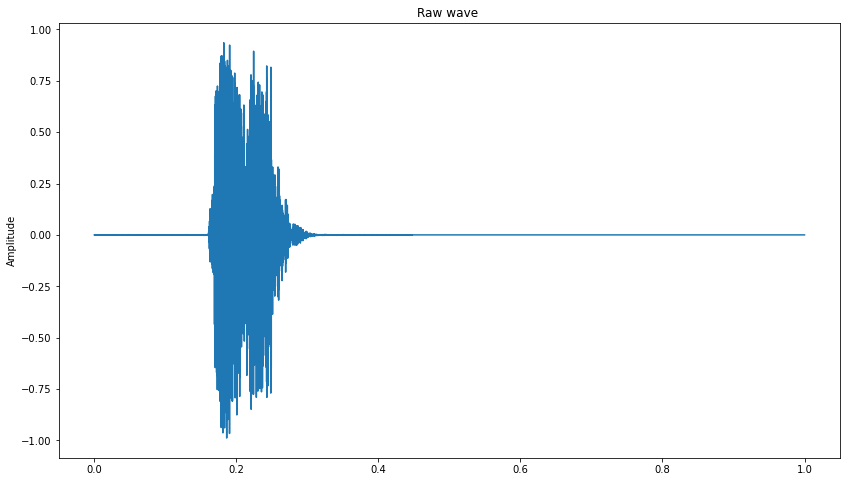

In [141]:
plot_time_series(wf)
display(Audio(wf, rate=sr))

In [142]:
wf_wn, sr = add_white_noise(wf, sr, 0.01)

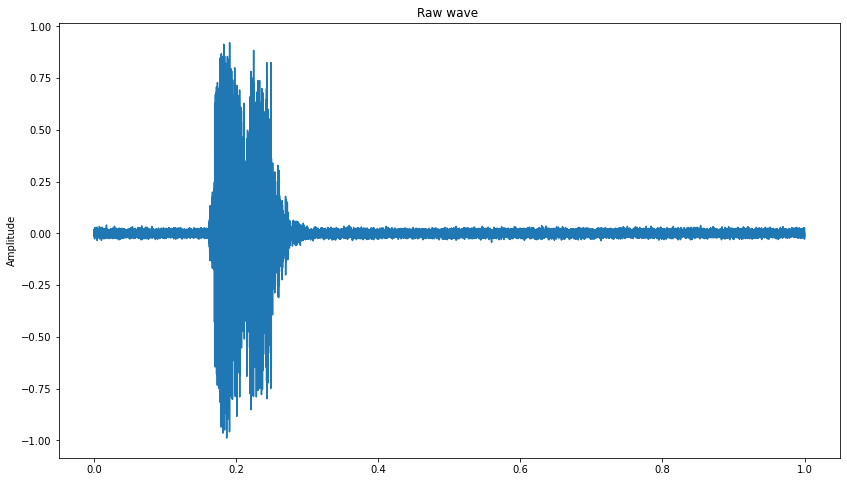

In [143]:
plot_time_series(wf_wn)
display(Audio(wf_wn, rate=sr))

In [144]:
wf_ts, sr = time_shift(wf, sr, 0.1)

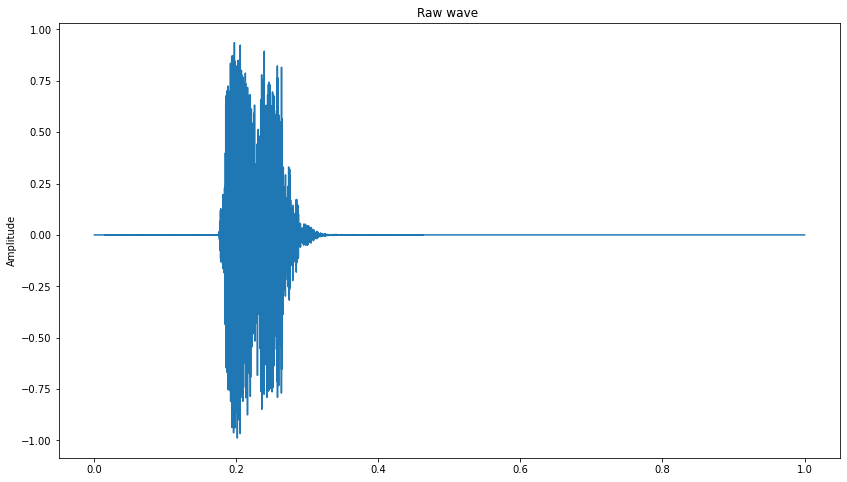

In [145]:
plot_time_series(wf_ts)
display(Audio(wf_ts, rate=sr))

In [185]:
wf_tstr, sr = time_stretch(wf, sr)

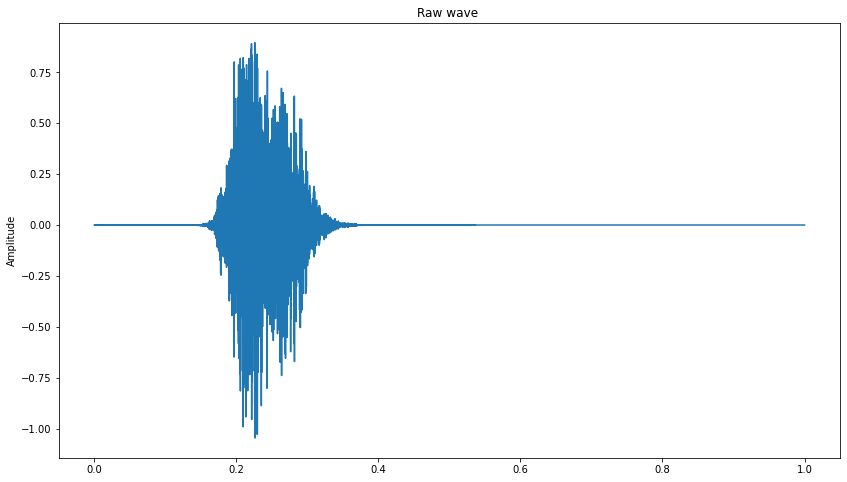

In [186]:
plot_time_series(wf_tstr)
display(Audio(wf_tstr, rate=sr))

In [146]:
np.sum(wf < 0.1)/len(wf)

0.962

In [153]:
wf_sound = wf[wf != 0]
wf_mute = np.where(wf == 0)
# wf_sound = wf_sound.tolist() + np.zeros((wf.shape[0] - wf_sound.shape[0])).tolist()
if len(wf_sound) < len(wf_mute):
    

In [166]:
wf_mute = np.where(wf == 0)
wf_mute[0]

array([    1,     2,     3, ..., 39997, 39998, 39999])

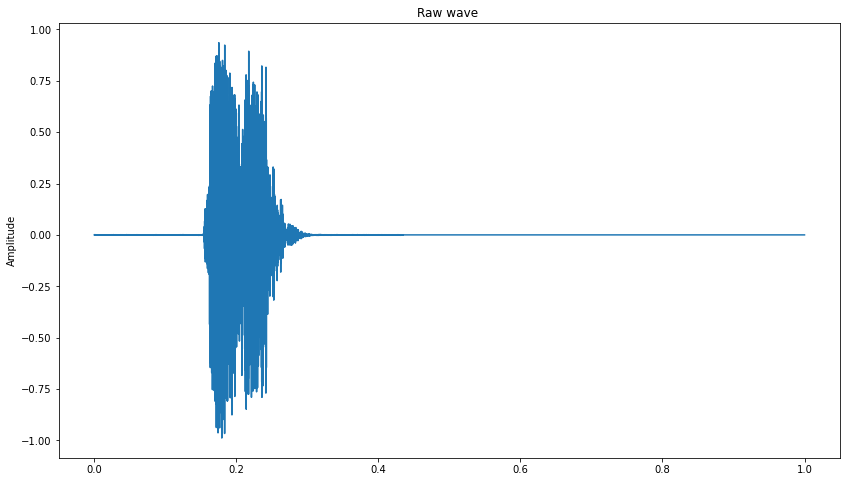

In [154]:
plot_time_series(wf_sound)
display(Audio(wf_sound, rate=sr))

In [9]:
files = os.listdir("train/train")

num_files_bf = len(files)
# to_remove = set()  # collect samples whose shape is different from input `shape`
count = 0

# other_files = [f + ".wav" for f in metadata[metadata["Remark"] == "Other"]["Filename"].values]


for path in files:
    # print(os.path.join(TRAIN_AUDIO_PATH, path))
    waveform, sample_rate = AudioProcessor.read(os.path.join("train/train", path))
    if np.sum(waveform == 0) / len(waveform) > 0.3:
        print("Label: {}".format(metadata[metadata["Filename"] == path.split('.')[0]]["Label"].values[0]))
        count += 1
print(count)

Label: 1
Label: 1
Label: 0
Label: 0
Label: 2
Label: 0
Label: 1
Label: 0
Label: 0
Label: 1
Label: 2
Label: 0
Label: 0
Label: 0
Label: 0
Label: 1
Label: 2
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 2
Label: 0
Label: 0
Label: 0
Label: 1
Label: 0
Label: 3
Label: 0
Label: 0
Label: 0
Label: 0
Label: 1
Label: 0
Label: 0
Label: 0
Label: 1
Label: 2
Label: 1
Label: 0
Label: 0
Label: 2
Label: 0
Label: 0
Label: 1
Label: 2
Label: 0
Label: 0
Label: 2
Label: 2
Label: 0
Label: 0
Label: 0
Label: 5
Label: 0
Label: 0
Label: 0
Label: 0
Label: 2
Label: 2
Label: 1
Label: 0
Label: 0
Label: 2
Label: 1
Label: 0
Label: 1
Label: 0
Label: 0
Label: 2
Label: 4
Label: 3
Label: 1
Label: 1
Label: 0
Label: 0
Label: 1
Label: 0
Label: 0
Label: 2
Label: 0
Label: 0
Label: 0
Label: 1
Label: 0
Label: 0
Label: 3
Label: 0
Label: 1
Label: 1
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 1
Label: 2
Label: 0
Label: 2
Label: 1
Label: 2
Label: 0
L

In [4]:
data = data_cleaning(train_audio_path, x_summary["waveform_shape"], metadata)

In [25]:
audio_dataset = AudioDataset(train_audio_path, data["x_file_paths"], y=data["y"],   label_name=configs["label_config"]["label_name"])

In [511]:
data = data_split(audio_dataset)

In [514]:
train(data, len(y_summary["label"]))

Using cpu device
AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (linear): Linear(in_features=16, out_features=6, bias=True)
)
Epoch 1 Batch 1 Result
	Loss: 1.772
Epoch 1 Batch 11 Result
	Loss: 1.814
Epoch 1 Batch 21 Result
	Loss: 1.818


In [57]:
pred = pd.read_csv("pred/05312318/pred.csv")

In [58]:
columns = pred.columns[1:]

In [59]:
mapping = {col: i for i, col in enumerate(columns)}

In [60]:
mapping

{'Barking': 0,
 'Howling': 1,
 'Crying': 2,
 'COSmoke': 3,
 'GlassBreaking': 4,
 'Other': 5}

In [63]:
pred.head()

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other,Label
0,public_00001,0.000466,0.001547,0.000397,4.500583e-03,1.187654e-03,9.919018e-01,Other
1,public_00002,0.001016,0.000007,0.002186,9.833624e-01,2.775309e-05,1.340017e-02,COSmoke
2,public_00003,0.999452,0.000066,0.000010,2.325940e-05,4.218162e-04,2.695161e-05,Barking
3,public_00004,0.027513,0.007098,0.042159,2.054061e-03,8.741018e-01,4.707367e-02,GlassBreaking
4,public_00005,0.890982,0.088820,0.020198,1.473256e-09,4.439293e-08,3.205598e-09,Barking


In [62]:
pred["Label"] = pred.iloc[:10,1:].idxmax(axis=1, skipna=True)

In [13]:
audio_dataset = AudioDataset(train_audio_path, data["x_file_paths"], configs["preprocess_config"])

In [14]:
# Load Model
model = AudioClassifier(6, configs["model_config"])
model.load_state_dict(torch.load("model/05312318/model.pt"))
model.eval()

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2

In [15]:
dataloader = DataLoader(audio_dataset, batch_size=configs["data_config"]["test_batch_size"],
                        shuffle=False, num_workers=0)

In [18]:
ret = validation_loop(dataloader, model, val=False)

Test starts


In [19]:
print(ret["pred"])

[1 5 5 ... 2 2 1]


In [105]:
metadata#[metadata["Filename"] == "train_00001"]["Label"].values[0]

,Filename,Label,Remark,Pred,Remark_label
0,train_00001,0,Barking,0,0
1,train_00002,0,Barking,0,0
2,train_00003,0,Barking,0,0
3,train_00004,0,Barking,0,0
4,train_00005,0,Barking,0,0
...,...,...,...,...,...
1195,train_01196,5,Dishes,5,10
1196,train_01197,5,Dishes,5,10
1197,train_01198,5,Dishes,5,10
1198,train_01199,5,Dishes,5,10


In [37]:
pred_label = [0] * 1200
for i, filename in enumerate(ret["filenames"]):
    idx = int(filename.split('_')[1]) - 1
    pred_label[idx] = ret["pred"][i]
metadata["Pred"] = pred_label

In [49]:
failed = np.where(metadata["Label"] != metadata["Pred"])[0]

In [52]:
for f_idx in failed[:1]:
    filepath = "train/train/train_{:05d}.wav".format(f_idx + 1)
    waveform, sample_rate = AudioProcessor.read(filepath)
    play_audio(waveform, sample_rate)

In [64]:
remark2idx = dict()
for i, rem in enumerate(metadata["Remark"].unique()):
    remark2idx[rem] = i


In [68]:
metadata["Remark_label"] = list(map(lambda x: remark2idx[x], metadata["Remark"]))

In [71]:
len(metadata["Remark_label"].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [74]:
cm = np.array([[31, 0, 2, 0, 0, 0],
 [ 1, 30, 1,  0,  0,  1],
 [ 3, 7, 40,  0,  0,  0],
 [ 1, 0,  1, 33,  0,  1],
 [ 0, 0,  0,  3, 44,  0],
 [ 0, 1,  3,  0,  4, 33]])

In [75]:
print(cm)

[[31  0  2  0  0  0]
 [ 1 30  1  0  0  1]
 [ 3  7 40  0  0  0]
 [ 1  0  1 33  0  1]
 [ 0  0  0  3 44  0]
 [ 0  1  3  0  4 33]]


In [87]:
for i, row in enumerate(cm):
    # print("Label {}".format(i + 1))
    # print("Accuracy: {}".format(round(row[i] / np.sum(row), 4)))
    print("Most likely confused with label {}".format(row.argsort()[-2]))

Most likely confused with label 2
Most likely confused with label 5
Most likely confused with label 1
Most likely confused with label 5
Most likely confused with label 3
Most likely confused with label 4


In [53]:
from sklearn.metrics import confusion_matrix

In [55]:
confusion_matrix(true, pred)

array([[0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 2, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1]])

### Resource:
* scipy.io.wavfile.read
* torchaudio
* librosa

### TODOs:
* Data Augmentation \
    -> Random Time Shift \
    -> Time and Frequency Masking

In [451]:
metadata = pd.read_csv("./train/meta_train.csv")

In [23]:
metadata["Label"].value_counts()

5    201
0    200
1    200
2    200
3    200
4    199
Name: Label, dtype: int64

In [453]:
train_y = metadata["Label"]

In [454]:
files = os.listdir("./train/train")
len(files)

1200

In [455]:
label = metadata["Label"].unique()
print("Number of label: {}".format(len(label)))
print("Label list: {}".format(label))

Number of label: 6
Label list: [0 1 2 3 4 5]


In [456]:
remark = metadata["Remark"].unique()
print("Number of remark: {}".format(len(remark)))
print("remark list: {}".format(remark))

Number of remark: 11
remark list: ['Barking' 'Howling' 'Crying' 'COSmoke' 'GlassBreaking' 'Other' 'Vacuum'
 'Blender' 'Electrics' 'Cat' 'Dishes']


Caution: Labels in the dataset is not a one-to-one mapping to remark. There are 11 types of remark in `Remark` column. Should use both `Label` and `Remark` column to do classification

### Set path

In [457]:
TRAIN_AUDIO_PATH = "./train/train"

## Audio preprocessing + Data Exploration

In [458]:
class AudioProcessor:
    def read(audio_file):
        """Load an audio file. Return the signal as a tensor and the sample rate"""
        waveform, sample_rate = torchaudio.load(audio_file)
        return (waveform, sample_rate) #if waveform.shape == self.shape else None
    
    def spectro_gram(waveform, sample_rate, n_mels=64, n_fft=1024, hop_len=None):
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(waveform)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

In [459]:
waveform, sample_rate = AudioProcessor.read(os.path.join(TRAIN_AUDIO_PATH, files[10]))

In [460]:
waveform.shape

torch.Size([1, 40000])

### Data Cleaning

In [461]:
files = os.listdir("./train/train")

shape = waveform.shape
print("Normal shape: {}\n".format(shape))

num_files = len(files)
to_remove = []
count = 0
for path in files:
#     print(os.path.join(TRAIN_AUDIO_PATH, path))
    waveform, sample_rate = audio_processor.read(os.path.join(TRAIN_AUDIO_PATH, path))
    if waveform.shape != shape:
        to_remove.append(path)
        count += 1
        print("Anomaly Shape Detected: {}\nShape: {}\n".format(path, waveform.shape))

for file in to_remove:
    drop_idx = metadata[metadata["Filename"] == file.split('.')[0]].index
    metadata = metadata.drop(drop_idx)
    files.remove(file)
    
print("Total Anomaly: {}".format(count))
print("Before deleting anomaly: {} numbers of audios".format(num_files))
print("After deleting anomaly: {} numbers of audios".format(len(files)))

Normal shape: torch.Size([1, 40000])

Anomaly Shape Detected: train_01046.wav
Shape: torch.Size([1, 16362])

Total Anomaly: 1
Before deleting anomaly: 1200 numbers of audios
After deleting anomaly: 1199 numbers of audios


##### Only one training data with different shape -> Just ignore it

In [462]:
print("Number of valid sample x: {}".format(len(files)))
print("Number of valid sample y: {}".format(len(metadata)))

Number of valid sample x: 1199
Number of valid sample y: 1199


### Create a Pytorch Dataset

In [463]:
class AudioDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, path_prefix, files, y):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path_prefix = path_prefix
        self.files = files
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        filename = self.files[idx]
        filepath = os.path.join(self.path_prefix, filename)
        
        waveform, sample_rate = AudioProcessor.read(filepath)
        
        specgram = AudioProcessor.spectro_gram(waveform, sample_rate, n_mels=64, n_fft=1024, hop_len=None)
        
        y = self.y[self.y["Filename"] == filename.split('.')[0]]["Label"].to_numpy()
        
        sample = {'x': specgram, 'y': y}

        return sample

In [464]:
metadata[metadata["Filename"] == "train_01046"]

,Filename,Label,Remark


In [466]:
audio_dataset = AudioDataset(TRAIN_AUDIO_PATH, files, metadata)

In [467]:
audio_dataset[500]

{'x': tensor([[[-32.2916, -32.2916, -19.6115,  ..., -32.2916, -32.2916, -32.2916],
          [-32.2916, -32.2916, -18.8911,  ..., -32.2916, -32.2916, -32.2916],
          [-32.2916, -30.4037, -16.0444,  ..., -32.2916, -32.2916, -32.2916],
          ...,
          [-28.8417,  -8.9955,  -2.5214,  ..., -32.2916, -32.2916, -32.2916],
          [-28.3178,  -8.9373,  -3.8161,  ..., -32.2916, -32.2916, -32.2916],
          [-32.2916, -14.6754,  -6.4746,  ..., -32.2916, -32.2916, -32.2916]]]),
 'y': array([1])}

In [468]:
num_items = len(audio_dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(audio_dataset, [num_train, num_val])

### Create a Dataloader

In [469]:
train_dataloader = DataLoader(train_ds, batch_size=32,
                        shuffle=True, num_workers=0)

val_dataloader = DataLoader(val_ds, batch_size=32,
                        shuffle=False, num_workers=0)

In [470]:
for i_batch, sample_batched in enumerate(audio_dataloader):
    print(i_batch, sample_batched['x'].size(),
          sample_batched['y'].size())
    if i_batch == 1:
        break


0 torch.Size([32, 1, 64, 79]) torch.Size([32, 1])
1 torch.Size([32, 1, 64, 79]) torch.Size([32, 1])


In [471]:
print("Model Input Shape: {}".format(sample_batched['x'].size()))

Model Input Shape: torch.Size([32, 1, 64, 79])


### Build a CNN Model

In [472]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [473]:
class AudioClassifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
        
        # Linear Classifier
        self.pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(in_features=16, out_features=num_class)

    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.pooling(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.linear(x)

        # Final output
        return x

In [474]:
# Create the model and put it on the GPU if available
model = AudioClassifier(num_class = len(label))
device = torch.device(device)
model = model.to(device)
print(model)

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (linear): Linear(in_features=16, out_features=6, bias=True)
)


In [475]:
def training(train_dataloader, val_dataloader, model, loss_fn, optimizer, num_epochs):
    # Loss Function, Optimizer and Scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dataloader)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dataloader):
            x, y_true = data['x'].to(device), data['y'].to(device).reshape(-1)

            # Normalize the inputs
            mean, std = x.mean(), x.std()
            x = (x - mean) / std

            # forward + backward + optimize
            outputs = model(x)
            loss = loss_fn(outputs, y_true)

            # Backpropagation
            optimizer.zero_grad()   # Zero the parameter gradients

            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, y_pred = torch.max(outputs, 1)
            # Count of predictions that matched the target label
            correct_prediction += (y_pred == y_true).sum().item()
            total_prediction += y_pred.shape[0]

            if i % 10 == 0:    # print every 10 mini-batches
                oh_ytrue = torch.nn.functional.one_hot(y_true)
                y_prob = torch.nn.functional.softmax(outputs, dim=1).detach().numpy()
                auc = roc_auc_score(oh_ytrue, y_prob, multi_class="ovr")
                print("Epoch {} Batch {} Result".format(epoch + 1, i + 1))
                print('\tLoss: %.3f' % (running_loss / (i + 1)))

        val_acc, val_avg_loss, val_auc = validation_loop(val_dataloader, model, loss_fn)

        # Print stats at the end of the epoch
        num_batches = len(train_dataloader)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        
        print("Epoch: {}".format(epoch + 1))
        print("Train Stats:")
        print(f'\tLoss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

        print("Validation Stats:")
        print(f'\tLoss: {val_avg_loss:.2f}, Accuracy: {val_acc:.2f}, Auc: {val_auc:.2f}')

    print('Finished Training')

In [476]:
def validation_loop(val_dataloader, model, loss_fn):
    size = len(val_dataloader.dataset)

    val_loss = 0
    correct_prediction = 0
    total_prediction = 0
    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            x, y_true = data['x'].to(device), data['y'].to(device).reshape(-1)

            # Normalize the inputs
            mean, std = x.mean(), x.std()
            x = (x - mean) / std

            # forward + backward + optimize
            outputs = model(x)
            y_prob = torch.nn.functional.softmax(outputs, dim=1)

            val_loss += loss_fn(outputs, y_true).item()

            # Get the predicted class with the highest score
            _, y_pred = torch.max(outputs, 1)

            # Count of predictions that matched the target label
            correct_prediction += (y_pred == y_true).sum().item()
            total_prediction += y_pred.shape[0]

            y_true_all.append(y_true.cpu())
            y_pred_all.append(y_pred.cpu())
            y_prob_all.append(y_prob.cpu())

    acc = correct_prediction/total_prediction
    
    # oh_ytrue = torch.nn.functional.one_hot(y_true)
    # y_prob = torch.nn.functional.softmax(outputs, dim=1).detach().numpy()
    # auc = roc_auc_score(oh_ytrue, y_prob, multi_class="ovr")

    # y_prob = torch.nn.functional.softmax(outputs, dim=1)
    y_true_all = torch.cat(y_true_all, dim = 0).detach().cpu().numpy()
    y_pred_all = torch.cat(y_pred_all, dim = 0).detach().cpu().numpy()
    y_prob_all = torch.cat(y_prob_all, dim = 0).detach().cpu().numpy()

    auc = roc_auc_score(y_true_all, y_prob_all, multi_class="ovr")

    return acc, val_loss / size, auc


In [477]:
loss_fnc = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

training(train_dataloader, val_dataloader, model, loss_fnc, optimizer, num_epochs)

Epoch 1 Batch 1 Result
	Loss: 1.812
Epoch 1 Batch 11 Result
	Loss: 1.787
Epoch 1 Batch 21 Result
	Loss: 1.783
Epoch: 1
Train Stats:
	Loss: 1.79, Accuracy: 0.16
Validation Stats:
	Loss: 0.06, Accuracy: 0.20, Auc: 0.60
Epoch 2 Batch 1 Result
	Loss: 1.834
Epoch 2 Batch 11 Result
	Loss: 1.767
Epoch 2 Batch 21 Result
	Loss: 1.770
Epoch: 2
Train Stats:
	Loss: 1.76, Accuracy: 0.21
Validation Stats:
	Loss: 0.06, Accuracy: 0.25, Auc: 0.66
Epoch 3 Batch 1 Result
	Loss: 1.724
Epoch 3 Batch 11 Result
	Loss: 1.735
Epoch 3 Batch 21 Result
	Loss: 1.725
Epoch: 3
Train Stats:
	Loss: 1.71, Accuracy: 0.24
Validation Stats:
	Loss: 0.06, Accuracy: 0.30, Auc: 0.72
Epoch 4 Batch 1 Result
	Loss: 1.676
Epoch 4 Batch 11 Result
	Loss: 1.650
Epoch 4 Batch 21 Result
	Loss: 1.658
Epoch: 4
Train Stats:
	Loss: 1.65, Accuracy: 0.30
Validation Stats:
	Loss: 0.05, Accuracy: 0.34, Auc: 0.77
Epoch 5 Batch 1 Result
	Loss: 1.659
Epoch 5 Batch 11 Result
	Loss: 1.617
Epoch 5 Batch 21 Result
	Loss: 1.601
Epoch: 5
Train Stats:


In [ ]:
audio_dataloader[37]

In [175]:
print(len(audio_dataset))

1200


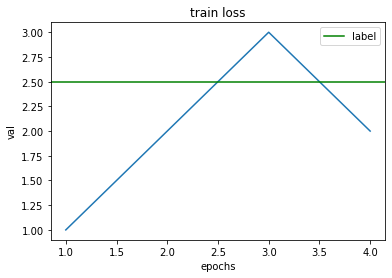

In [33]:
plt.plot(np.arange(1, 5), [1, 2, 3, 2])
plt.title("train loss")
plt.xlabel("epochs")
plt.ylabel("val")
# plt.savefig("temp.jpg")
plt.axhline(y=2.5, color='g', linestyle='-', label='label')
plt.legend()
plt.show()